# Cloning Quasars

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!) 

- Download the SDSS quasar data
- Upsample this distribution in two ways (but at least one of them), using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distributions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)
- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theoretical distribution to the measured SDSS data. Does that agree with your expectation? (Hint: It shouldn't. But why?)

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

from scipy.optimize import brentq
from scipy.stats import norm
from scipy.stats import uniform

from astroML.datasets import fetch_dr7_quasar
from astropy import cosmology

## Dataset

In [68]:
# Download the data

# Fetch the quasar data
data = fetch_dr7_quasar()

# Select the first 10000 points
data = data[:10000]

z = data['redshift']

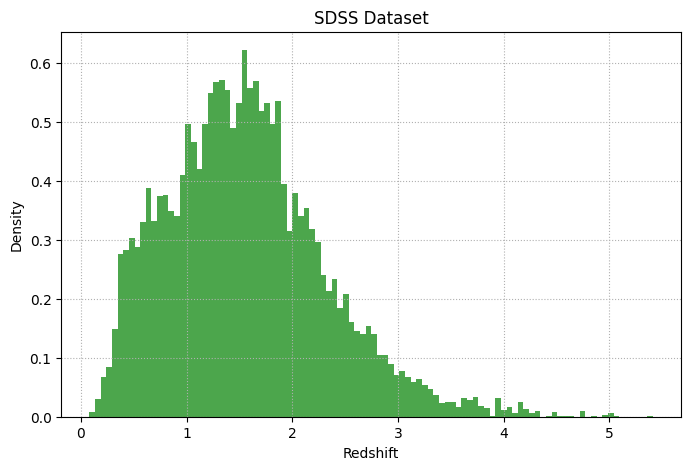

In [95]:
# Plot the SDSS dataset
plt.figure(figsize=(8, 5))
h, edges, figure = plt.hist(z, bins=100, color='green', alpha=0.7, density=True)
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.title("SDSS Dataset")
plt.grid(linestyle=':')
plt.show()

In [70]:
# General variables
N = 10000 # Number of sampling

bins = 100 # Number of bins
bin_centers = (edges[:-1] + edges[1:]) / 2  # Compute bin centers

## Rejection Sampling

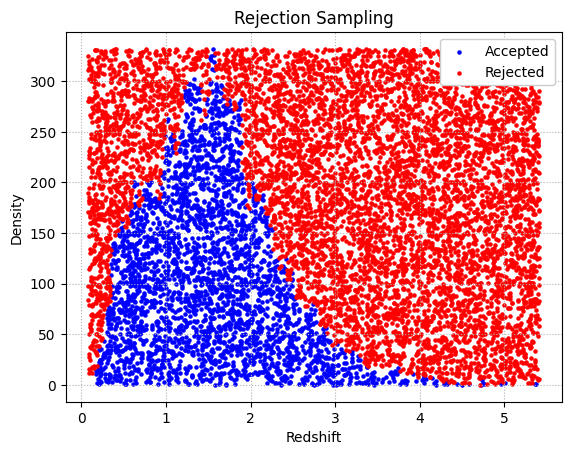

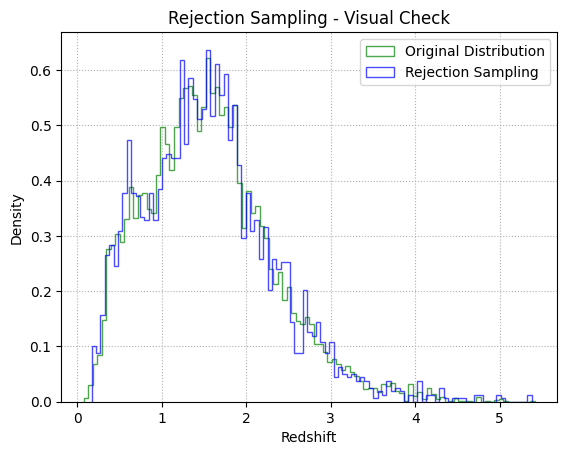

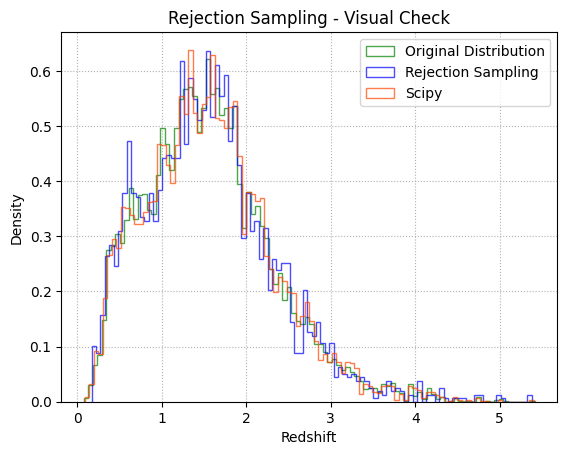

In [71]:
# Generate random points under a uniform distribution
x = np.random.uniform(min(z), max(z), N)
y = np.random.uniform(min(h), max(h), N)

i = np.digitize(x, edges) - 1 # Number of the bin corresponding to each x value generated

# Rejection sampling
valid_x = x[y <= h[i]]
valid_y = y[y <= h[i]]

# Plot
plt.scatter(valid_x, valid_y, c='blue', label="Accepted", s=5)
plt.scatter(x[y > h[i]], y[y > h[i]], c='red', label="Rejected", s=5)
plt.title("Rejection Sampling")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.legend(loc='upper right',framealpha=1.0)
plt.grid(linestyle=':')
plt.show()

# Visual check
plt.hist(z, bins, histtype='step', color='green', alpha=0.7, density=True, label="Original Distribution")
plt.hist(valid_x, bins, histtype='step', color='blue', alpha=0.7, density=True, label="Rejection Sampling")
plt.title("Rejection Sampling - Visual Check")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.legend()
plt.grid(linestyle=':')
plt.show()

# Scipy has it already implemented
disth = scipy.stats.rv_histogram((h, edges))

plt.hist(z, bins, color='green', histtype='step', alpha=0.7, density=True, label="Original Distribution")
plt.hist(valid_x, bins, color='blue', histtype='step', alpha=0.7, density=True, label="Rejection Sampling")
plt.hist(disth.rvs(size=N), bins, histtype='step', color='orangered', alpha=0.7, density=True, label="Scipy")
plt.title("Rejection Sampling - Visual Check")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.legend()
plt.grid(linestyle=':')
plt.show()

## Inverse Transform Sampling

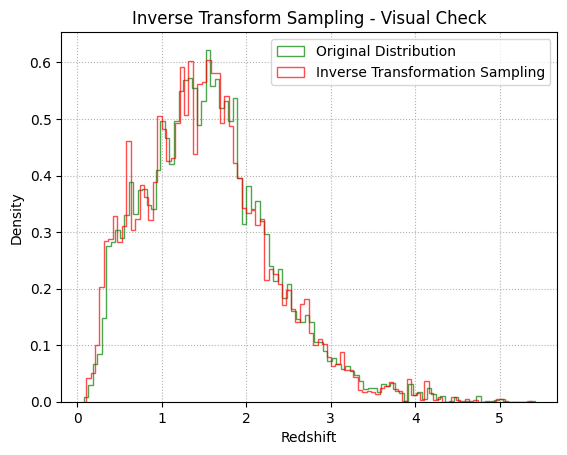

In [72]:
# Compute the cdf
cdf = np.cumsum(h) / np.sum(h)

# Compute the inverse cdf
inverse_cdf = scipy.interpolate.interp1d(cdf, bin_centers, bounds_error=False, fill_value=(bin_centers[0], bin_centers[-1]))

# Generate random values from a uniform distribution
eps = np.random.uniform(0, 1, N)
# Sample the inverse cdf in eps
samples = inverse_cdf(eps)

# Plot
plt.hist(z, bins, histtype='step', color="green", alpha=0.7, density=True, label="Original Distribution")
plt.hist(samples, bins, histtype='step', color="red", alpha=0.7, density=True, label="Inverse Transformation Sampling")
plt.title("Inverse Transform Sampling - Visual Check")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.legend()
plt.grid(linestyle=':')
plt.show()

## Cosmological Model

As suggested, let's try to assume that quasars are distributed uniformly in comoving volume in the Universe.

We use the cosmological parameters as measured by the Planck satellite, which is a flat $\Lambda_{CDM}$ model.

In [73]:
# Add cosmological model
cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.7 km / (Mpc s), Om0=0.31, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.049)

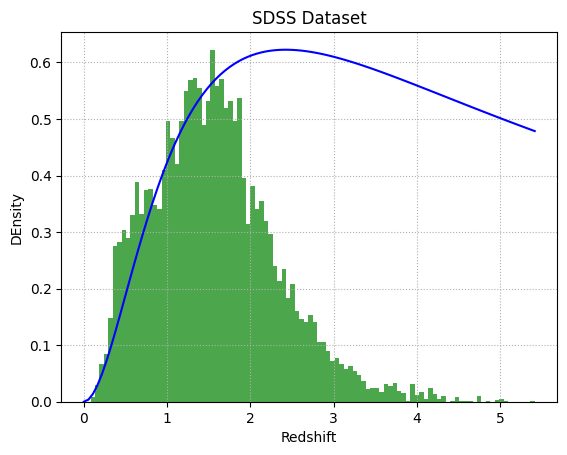

In [98]:
# use comoving volume function
z_vals = np.linspace(0, np.max(z), 100)

pdf_ =  np.pi * cosmology.Planck18.differential_comoving_volume(z_vals).value

peak_hist = np.max(h)

peak_model = np.max(pdf_)

scale_factor = peak_model / peak_hist  # match peaks
norm_pdf = pdf_ / scale_factor # Arbitrary normalization

plt.plot(z_vals, norm_pdf, color='blue', label='Cosmological Model')
plt.hist(z, bins, density = True, color='green', alpha=0.7, label='Original Distribution')
plt.title("SDSS Dataset")
plt.xlabel("Redshift")
plt.ylabel("DEnsity")
plt.grid(linestyle = ':')
plt.show()

The redshift distribution follows the model only at low redshift values. This means that quasars are not distributed uniformly in comoving volume.